In [1]:
import pandas as pd
import s3fs

In [ ]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "williamolivier"

FILE_PATH_S3_FVDEP = f"{MY_BUCKET}/diffusion/epci_6_clusters.csv"
with fs.open(FILE_PATH_S3_FVDEP, "rb") as file:
    epci_features = pd.read_csv(file)


In [ ]:
epci_features.sample()

étape 1 : Il faut choisir un clustering parmi les 4 (on demandera l'avis de Nicolas) et pour chaque cluster trouver une composition moyenne des transports en communs utilisé (ex 80% metro et 10% train et 10% bus pour le cluster ou y'a que paris, etc)

étape 2 : Il faut écrire un dictionnaire qui recense pour chaque type de transport en commun son émission moy/km 

étape 3 : Créer une nouvelle colonne sur un des 4 tableaux (selon le clustering retenu) qui donnerait une émission moyenne pour chaque EPCI (soit global, soit par type de flux (séparer rouge et jaune? à voir))

-> pour cette étape voir si + pertinent de prendre les flux entrant ou sortant ? ou une moyenne des 2 ?

étape 4 : trouver un moyen de repérer les mauvais élèves (par exemple ceux dont l'émission associée calculée est aberrante ou plus élevée par rapport aux autres EPCI du même cluster)

-> pour cette étape trouver un indicateurs pour détecter les mauvais élève (ex arbitraire 50% aus dessus de la moyenne) mais voir si on peut trouver un meilleur indicateur bien justifier

In [45]:
# Etape 1

# Pour l'instant choix du clustering à 7 clusters
# On prend en compte à la fois les flux entrants et les flux sortants pour faire les calculs

epci_features=epci_features_7 # il suffira de changer le numéro du clustering choisi ici

epci_features["nombre_total_de_flux_par_epci"]=(
    epci_features["nb_entrant_>50km_rouge"]
    +epci_features["nb_entrant_<50km_rouge"]
    +epci_features["nb_sortant_>50km_rouge"]
    +epci_features["nb_sortant_<50km_rouge"]
    +epci_features["nb_intra_rouge"]
    +epci_features["nb_entrant_>50km_vert"]
    +epci_features["nb_entrant_<50km_vert"]
    +epci_features["nb_sortant_>50km_vert"]
    +epci_features["nb_sortant_<50km_vert"]
    +epci_features["nb_intra_vert"]
    +epci_features["nb_entrant_>50km_jaune"]
    +epci_features["nb_entrant_<50km_jaune"]
    +epci_features["nb_sortant_>50km_jaune"]
    +epci_features["nb_sortant_<50km_jaune"]
    +epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en voiture
epci_features["proportion_individus_flux_rouges"] = (
    (epci_features["nb_entrant_>50km_rouge"]
    + epci_features["nb_entrant_<50km_rouge"]
    + epci_features["nb_sortant_>50km_rouge"]
    + epci_features["nb_sortant_<50km_rouge"]
    + epci_features["nb_intra_rouge"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail en transports en commun
epci_features["proportion_individus_flux_jaunes"] = (
    (epci_features["nb_entrant_>50km_jaune"]
    + epci_features["nb_entrant_<50km_jaune"]
    + epci_features["nb_sortant_>50km_jaune"]
    + epci_features["nb_sortant_<50km_jaune"]
    + epci_features["nb_intra_jaune"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

# Calcul de la proportion d'individus qui se rendent au travail à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_individus_flux_verts"] = (
    (epci_features["nb_entrant_>50km_vert"]
    + epci_features["nb_entrant_<50km_vert"]
    + epci_features["nb_sortant_>50km_vert"]
    + epci_features["nb_sortant_<50km_vert"]
    + epci_features["nb_intra_vert"])
    /epci_features["nombre_total_de_flux_par_epci"]
    )

print(epci_features["proportion_individus_flux_rouges"].head())
print(epci_features["proportion_individus_flux_jaunes"].head())
print(epci_features["proportion_individus_flux_verts"].head())
print(epci_features["proportion_individus_flux_rouges"].head()
    +epci_features["proportion_individus_flux_jaunes"].head()
    +epci_features["proportion_individus_flux_verts"].head())
# les résultats sont parfaitement logiques ici

0    0.744451
1    0.813836
2    0.719263
3    0.825774
4    0.772347
Name: proportion_individus_flux_rouges, dtype: float64
0    0.014824
1    0.042950
2    0.110643
3    0.025620
4    0.039409
Name: proportion_individus_flux_jaunes, dtype: float64
0    0.240725
1    0.143214
2    0.170094
3    0.148606
4    0.188245
Name: proportion_individus_flux_verts, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64


In [46]:
print(list(epci_features.columns))


['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'SIREN_EPCI', 'NOM', 'INSEE_COM', 'INSEE_DEP', 'POPULATION', 'Nb actifs à temps partiel', 'Nb ménages en 2021', 'Nb actifs occupés en 2021', 'geometry', 'MONO_DEP', 'INSEE_COM_list', 'INSEE_DEP_list', 'nb_entrant_<10km_vert', 'distance_entrant_<10km_vert', 'nb_sortant_<10km_vert', 'distance_sortant_<10km_vert', 'nb_entrant_<20km_vert', 'distance_entrant_<20km_vert', 'nb_sortant_<20km_vert', 'distance_sortant_<20km_vert', 'nb_entrant_<30km_vert', 'distance_entrant_<30km_vert', 'nb_sortant_<30km_vert', 'distance_sortant_<30km_vert', 'nb_entrant_<40km_vert', 'distance_entrant_<40km_vert', 'nb_sortant_<40km_vert', 'distance_sortant_<40km_vert', 'nb_entrant_<50km_vert', 'distance_entrant_<50km_vert', 'nb_sortant_<50km_vert', 'distance_sortant_<50km_vert', 'nb_entrant_>50km_vert', 'distance_entrant_>50km_vert', 'nb_sortant_>50km_vert', 'distance_sortant_>50km_vert', 'nb_intra_vert', 'distance_intra_vert', 'nb_entrant_<10km_jaune', 'distance_entr

In [47]:
# Même chose avec la distance

epci_features["distance_totale_de_flux_par_epci"]=(
    epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"]
    + epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"]
    + epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en voiture
epci_features["proportion_distance_flux_rouges"] = (
    (epci_features["distance_entrant_>50km_rouge"]*epci_features["nb_entrant_>50km_rouge"]
    + epci_features["distance_entrant_<50km_rouge"]*epci_features["nb_entrant_<50km_rouge"]
    + epci_features["distance_sortant_>50km_rouge"]*epci_features["nb_sortant_>50km_rouge"]
    + epci_features["distance_sortant_<50km_rouge"]*epci_features["nb_sortant_<50km_rouge"]
    + epci_features["distance_intra_rouge"]*epci_features["nb_intra_rouge"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus en transports en commun
epci_features["proportion_distance_flux_jaunes"] = (
    (epci_features["distance_entrant_>50km_jaune"]*epci_features["nb_entrant_>50km_jaune"]
    + epci_features["distance_entrant_<50km_jaune"]*epci_features["nb_entrant_<50km_jaune"]
    + epci_features["distance_sortant_>50km_jaune"]*epci_features["nb_sortant_>50km_jaune"]
    + epci_features["distance_sortant_<50km_jaune"]*epci_features["nb_sortant_<50km_jaune"]
    + epci_features["distance_intra_jaune"]*epci_features["nb_intra_jaune"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

# Calcul de la proportion de kilomètres qui sont parcourus à pieds / en vélo / qui télétravaillent ou travaillent à domicile
epci_features["proportion_distance_flux_verts"] = (
    (epci_features["distance_entrant_>50km_vert"]*epci_features["nb_entrant_>50km_vert"]
    + epci_features["distance_entrant_<50km_vert"]*epci_features["nb_entrant_<50km_vert"]
    + epci_features["distance_sortant_>50km_vert"]*epci_features["nb_sortant_>50km_vert"]
    + epci_features["distance_sortant_<50km_vert"]*epci_features["nb_sortant_<50km_vert"]
    + epci_features["distance_intra_vert"]*epci_features["nb_intra_vert"])
    /epci_features["distance_totale_de_flux_par_epci"]
    )

print(epci_features["proportion_distance_flux_rouges"].head())
print(epci_features["proportion_distance_flux_rouges"].mean())
print(epci_features["proportion_distance_flux_jaunes"].head())
print(epci_features["proportion_distance_flux_jaunes"].mean())
print(epci_features["proportion_distance_flux_verts"].head())
print(epci_features["proportion_distance_flux_verts"].mean())
print((epci_features["proportion_distance_flux_rouges"]+epci_features["proportion_distance_flux_jaunes"]+epci_features["proportion_distance_flux_verts"]).head())
# La somme de toutes les proportions fait 1
# Les résultats sont logiques

0    0.718892
1    0.798117
2    0.624328
3    0.839840
4    0.817619
Name: proportion_distance_flux_rouges, dtype: float64
0.7824275620054975
0    0.128145
1    0.122134
2    0.305475
3    0.105396
4    0.105409
Name: proportion_distance_flux_jaunes, dtype: float64
0.12784286167720002
0    0.152964
1    0.079749
2    0.070197
3    0.054764
4    0.076972
Name: proportion_distance_flux_verts, dtype: float64
0.0897295763173026
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
dtype: float64


In [48]:
# Etape 2

# SOURCE : https://www.data.gouv.fr/fr/datasets/emission-de-co2e-par-voyageur-kilometre-sur-le-reseau/

pollution_au_km={
    "voiture":"0.097", 
    "bus":"0.092", 
    "metro":"0.0038",
    "tram":"0.0032",
    "transilien":"0.0066",
    "TER":"0.02693"
}

In [5]:
# FLORE
# Je pars du principe que ce sera 4 ou 5 clusters 
# Je fais les 5 clusters de la carte ici (éventuellement fusionner les 2 derniers pour 4 ?)

pollution_au_km_TC={
    "Bus": 0.092, 
    "Métro/tram/transilien": 0.0045,
    "TER": 0.02693
}


pollution_au_km_flux_rouge = 0.097


# Dictionnaire avec les valeurs choisies pour chaque mode de TC en % de la distance parcourue en TC 

flux_jaunes_detail = {
    "Paris": {
        "Métro/tram/transilien": 0.8,
        "TER": 0.1,   
        "Bus": 0.1    
    },
    "Banlieue proche de Paris": {
        "Métro/tram/transilien": 0.7,  
        "TER": 0.1,    
        "Bus": 0.2    
    },
    "Grandes villes": {
        "Métro/tram/transilien": 0.5,  
        "TER": 0.2,   
        "Bus": 0.3    
    },
    "Villes moyennes": {
        "Métro/tram/transilien": 0.1, 
        "TER": 0.4,    
        "Bus": 0.5     
    },
    "Autres": {
        "Métro/tram/transilien" : 0,
        "TER" : 0.5,
        "Bus" : 0.5
    }
}


# ici flux intra + moyenne des flux sortants et entrants 
epci_features_5["moyenne_flux_rouges"] = (
    epci_features_5['distance_intra_rouge']*epci_features_5['nb_intra_rouge'] + (
    epci_features_5['distance_entrant_<50km_rouge']*epci_features_5['nb_entrant_<50km_rouge'] + 
    epci_features_5['distance_entrant_>50km_rouge']*epci_features_5['nb_entrant_>50km_rouge'] + 
    epci_features_5['distance_sortant_<50km_rouge']*epci_features_5['nb_sortant_<50km_rouge'] +
    epci_features_5['distance_sortant_>50km_rouge']*epci_features_5['nb_sortant_>50km_rouge'])/2)
    

epci_features_5['pollution_flux_rouges'] = epci_features_5['moyenne_flux_rouges'] * pollution_au_km_flux_rouge

epci_features_5["moyenne_flux_jaunes"] = (
    epci_features_5['distance_intra_jaune']*epci_features_5['nb_intra_jaune'] + (
    epci_features_5['distance_entrant_<50km_jaune']* epci_features_5['nb_entrant_<50km_jaune'] +
    epci_features_5['distance_entrant_>50km_jaune']* epci_features_5['nb_entrant_>50km_jaune'] +
    epci_features_5['distance_sortant_<50km_jaune']* epci_features_5['nb_sortant_<50km_jaune'] +
    epci_features_5['distance_sortant_>50km_jaune']* epci_features_5['nb_sortant_>50km_jaune'])/2)

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Appliquer la répartition pour chaque mode de transport en fonction du cluster
    epci_features_5[f'distance_{transport}'] = epci_features_5['moyenne_flux_jaunes'] * \
        epci_features_5['cluster'].map(lambda cluster: flux_jaunes_detail.get(cluster, {}).get(transport, 0))

for transport in ['Métro/tram/transilien', 'TER', 'Bus']:
    # Calculer la pollution en multipliant la distance par les émissions par km pour chaque mode
    epci_features_5[f'pollution_{transport}'] = epci_features_5[f'distance_{transport}'] * pollution_au_km_TC[transport]

epci_features_5['pollution_flux_jaunes'] = epci_features_5['pollution_Métro/tram/transilien'] + epci_features_5['pollution_TER'] + epci_features_5['pollution_Bus']

In [6]:
# Aucune idée de comment vérifier l'ordre de grandeur des résultats


# Identifier les mauvais élèves

epci_features_5['pollution_totale'] = (
    epci_features_5['pollution_flux_rouges'] + epci_features_5['pollution_flux_jaunes']
)

# Trier les EPCI par pollution totale dans chaque cluster
mauvais_eleves_par_cluster = epci_features_5.sort_values(['cluster', 'pollution_totale'], ascending=[True, False])

# Garder les 5 pires par cluster
top_n = 5
mauvais_eleves_par_cluster = mauvais_eleves_par_cluster.groupby('cluster').head(top_n)

# Affichage résumé
cols = ['cluster', 'NOM', 'pollution_totale']
print(mauvais_eleves_par_cluster[cols])



     cluster                                                NOM  \
549        0  ['Embres-et-Castelmaure', 'Fontjoncouse', 'Fit...   
472        0  ['Montreuil-sur-Mer', 'Camiers', 'Étaples', 'B...   
882        0  ['Saint-Caprais-de-Bordeaux', 'Langoiran', 'Le...   
840        0  ['Landivisiau', 'Bodilis', 'Commana', 'Saint-V...   
245        0  ['Sempy', 'Beaurainville', 'Noyelles-lès-Humiè...   
262        1  ['Puteaux', 'Nanterre', 'Vaucresson', 'Saint-C...   
270        1  ['Claye-Souilly', 'Chennevières-lès-Louvres', ...   
265        1  ['Orly', 'Juvisy-sur-Orge', 'Chevilly-Larue', ...   
272        1  ['Ballainvilliers', 'Linas', 'Montlhéry', 'Gif...   
284        1  ['Juziers', 'Mantes-la-Jolie', 'Arnouville-lès...   
256        2  ['Paris 2e Arrondissement', 'Paris 9e Arrondis...   
836        3  ['Rédené', 'Clohars-Carnoët', 'Saint-Thurien',...   
830        3  ['Guipavas', 'Plouzané', 'Le Relecq-Kerhuon', ...   
45         3  ['Saint-Laurent-de-la-Salanque', 'Saint-Nazair..

/tmp/ipykernel_161509/2828719507.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


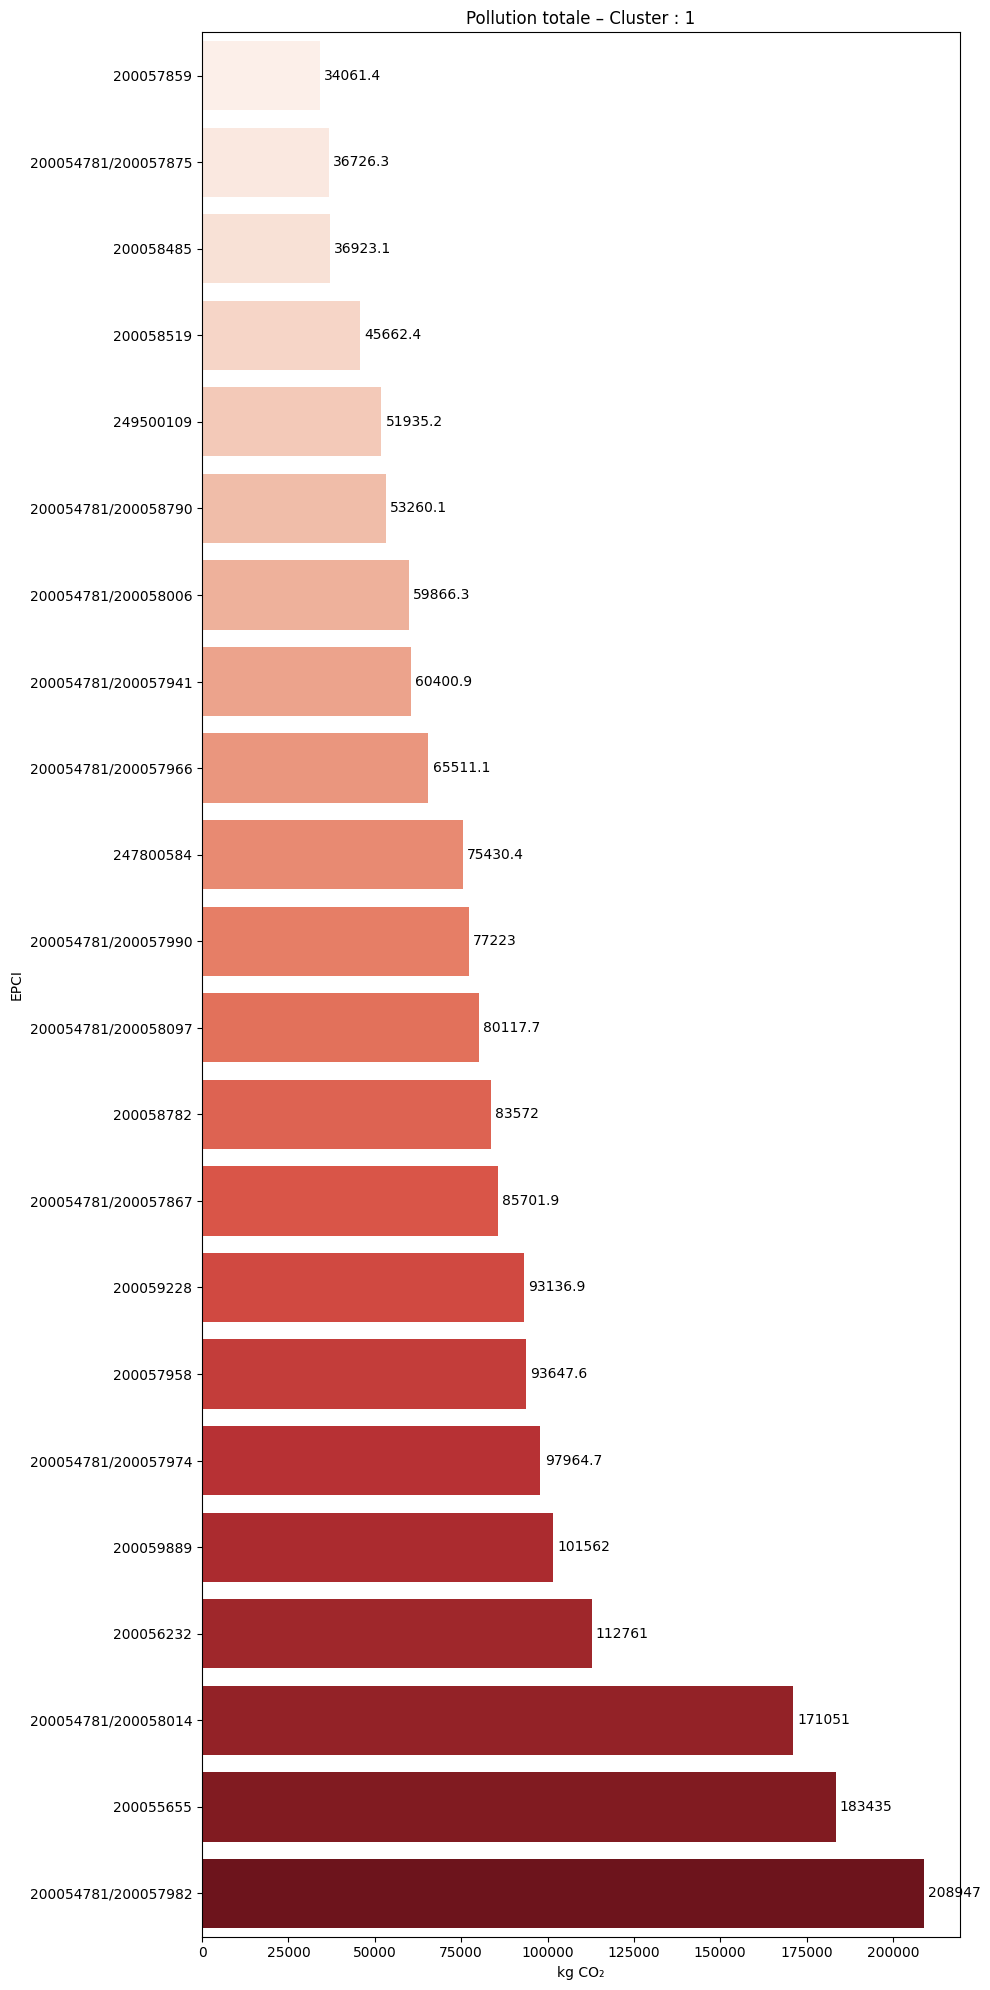

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choisis le cluster que tu veux visualiser
cluster_cible = 1  # ← à adapter selon tes données

# Filtrer les EPCI du cluster choisi
subset = epci_features_5[epci_features_5['cluster'] == cluster_cible].copy()

# Trier les EPCI du moins au plus polluant
subset = subset.sort_values('pollution_totale', ascending=True)

# Afficher le nom si disponible, sinon l’index
label_col = 'SIREN_EPCI' 

# Création du barplot
plt.figure(figsize=(10, max(20, len(subset) * 0.3)))  # ajuste la hauteur automatiquement
barplot = sns.barplot(
    data=subset,
    x='pollution_totale',
    y=label_col,
    palette='Reds'
)

plt.title(f"Pollution totale – Cluster : {cluster_cible}")
plt.xlabel("kg CO₂")
plt.ylabel("EPCI")

# Affichage des valeurs sur les barres
for container in barplot.containers:
    barplot.bar_label(container, label_type="edge", padding=3)

plt.tight_layout()
plt.show()


